Make sure you've got the latest & greatest

In [1]:
!(cd /opt/tvb-library; git pull --rebase)

remote: Counting objects: 5, done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 5 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (5/5), done.
From https://github.com/the-virtual-brain/tvb-library
   81d2ed2..1d306f5  trunk      -> origin/trunk
First, rewinding head to replay your work on top of it...
Fast-forwarded trunk to 1d306f5bc5da93eca8231f40fd5e6bf4104ae208.


In [2]:
from mpl_toolkits.mplot3d import Axes3D
%pylab nbagg
import mne
import nibabel
from tvb.simulator.lab import *
from tvb.datatypes.sensors import SensorsMEG
from tvb.datatypes.projections import ProjectionSurfaceMEG, ProjectionMatrix
from tvb.datatypes.surfaces import CorticalSurface, Surface
from tvb.datatypes.region_mapping import RegionMapping

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
fwd = mne.read_forward_solution('ol-fwd.fif')
fixed_fwd = mne.convert_forward_solution(fwd, force_fixed=True)

Reading forward solution from ol-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (20484 sources, 248 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
    Cartesian source orientations...
[done]
    Changing to fixed-orientation forward solution with surface-based source orientations...
    [done]


Make transform from MEG sensor coordinates to MRI space

In [4]:
d2h = mne.io.read_info('1-raw.fif')['dev_head_t']
h2m = mne.read_trans('ol-trans.fif')

d2m = mne.transforms.combine_transforms(d2h, h2m, d2h['from'], h2m['to'])
d2m

<Transform  |  MEG device->MRI (surface RAS)>
[[ 0.99770932 -0.05806276 -0.03471082  0.00250748]
 [ 0.06260618  0.98690313  0.14866981 -0.05649492]
 [ 0.02562403 -0.15050239  0.98827753  0.05056523]
 [ 0.          0.          0.          1.        ]]

Apply transform & extract source positions as well

<IPython.core.display.Javascript object>


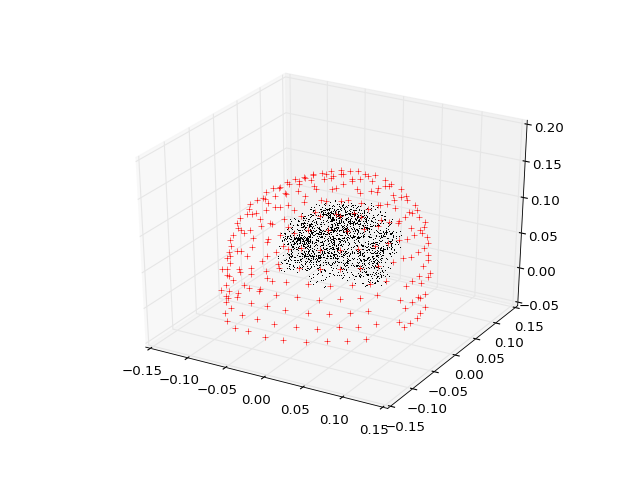

In [8]:
ch_xyz_dev = array([ch['loc'][:3] for ch in fixed_fwd['info']['chs']])
ch_ori_dev = array([ch['loc'][-3:] for ch in fixed_fwd['info']['chs']])

ch_xyz_mri = d2m['trans'].dot(c_[ch_xyz_dev, ones(len(ch_xyz_dev))].T)[:3].T
ch_ori_mri = d2m['trans'].dot(c_[ch_ori_dev, ones(len(ch_xyz_dev))].T)[:3].T
cx, cy, cz = ch_xyz_mri.T

sx, sy, sz = fixed_fwd['source_rr'][::10].T

# double check
figure()
ax = subplot(111, projection='3d')
ax.plot(sx, sy, sz, 'k,')
ax.plot(cx, cy, cz, 'r+')

Combine resampled surfaces

In [9]:
vl, fl = nibabel.freesurfer.read_geometry('/opt/freesurfer/subjects/ol/surf/lh.pial.fsaverage5')
vr, fr = nibabel.freesurfer.read_geometry('/opt/freesurfer/subjects/ol/surf/rh.pial.fsaverage5')

vt = vstack([vl, vr])
ft = vstack([fl, fr + len(vl)])

# construct map from FreeSurfer ROI name to node index
fs_default = {}
with open('/opt/mrtrix3/share/mrtrix3/labelconvert/fs_default.txt') as fd:
    for line in fd.readlines():
        line = line.strip()
        if line and not line.startswith('#'):
            val, _, name, _, _, _, _ = line.split()
            fs_default[name] = int(val)

# apply map to each surface's annotation & combine
annots = []
for hemi in 'lh rh'.split():
    annot, _, roi_names = nibabel.freesurfer.read_annot(
        '/opt/freesurfer/subjects/ol/label/'
        '%s.aparc.annot.fsaverage5' % (hemi, )
    )
    for roi_idx, roi_name in enumerate(roi_names):
        if roi_name in ('unknown', 'corpuscallosum'):
            node_idx = 0
        else:
            node_idx = fs_default['ctx-%s-%s' % (hemi, roi_name)]
        annot[annot == roi_idx] = node_idx
    annots.append(annot)

total_annot = hstack(annots)
total_annot[total_annot == -1] = 0

Load connectome data

<IPython.core.display.Javascript object>


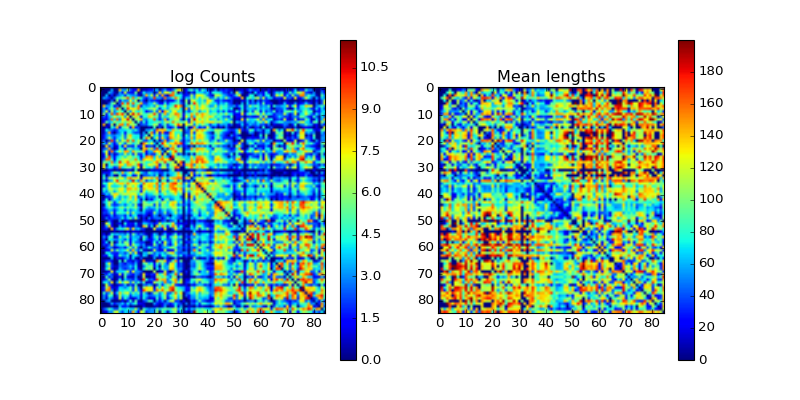

In [10]:
counts = loadtxt('/opt/freesurfer/subjects/ol/dwi/counts.txt')
lengths = loadtxt('/opt/freesurfer/subjects/ol/dwi/lengths.txt')
counts = counts + counts.T
lengths = lengths + lengths.T
np.fill_diagonal(counts, 0)
np.fill_diagonal(lengths, 0)

cortical = np.zeros(counts.shape[0], dtype=bool)
cortical[np.unique(total_annot[total_annot>0])] = True

# pad for unknown region
counts = c_[zeros(85), c_[zeros(84), counts].T].T
lengths = c_[zeros(85), c_[zeros(84), lengths].T].T
cortical = r_[False, cortical]

figure(3, figsize=(10, 5))
subplot(121), imshow(log(counts + 1)), colorbar(), title('log Counts')
subplot(122), imshow(lengths), colorbar(), title('Mean lengths');

Get node centers & orientations

In [11]:
# construct map from FreeSurfer ROI value to node index
fs_node_idx = {}
with open('/opt/freesurfer/FreeSurferColorLUT.txt') as fd:
    for line in fd.readlines():
        line = line.strip()
        if line and not line.startswith('#'):
            val, name, _, _, _, _ = line.split()
            if name in fs_default:
                fs_node_idx[int(val)] = fs_default[name]

node_img = nibabel.load('/opt/freesurfer/subjects/ol/mri/aparc+aseg.mgz')
node_dat = node_img.get_data()

node_centers = np.zeros((counts.shape[0], 3))
for uval in np.unique(node_dat):
    if uval not in fs_node_idx:
        continue
    ijk = np.argwhere(node_dat == uval)
    xyz = node_img.affine.dot(c_[ijk, ones(len(ijk))].T)[:3].T
    node_centers[fs_node_idx[uval]] = xyz.mean(axis=0)

Construct TVB data structures for the cortical surface, connectivty & forward model

In [51]:
conn = connectivity.Connectivity(
    weights=counts / counts.max(),
    tract_lengths=lengths,
    cortical=cortical,
    centres=node_centers,
    orientations=ones_like(node_centers),
)

pial_surface = CorticalSurface(
    vertices=vt,
    triangles=ft
)

sens_meg = SensorsMEG(
    number_of_sensors=248,
    locations=ch_xyz_mri,
    orientations=ch_ori_mri
)

proj_meg = ProjectionSurfaceMEG(
    sources=pial_surface,
    sensors=sens_meg,
    projection_data=hstack([fixed_fwd['sol']['data'], zeros((248, 16))])
)

reg_map = RegionMapping(
    array_data=total_annot,
    connectivity=conn,
    surface=pial_surface
)

mon_meg = monitors.MEG(
    sensors=sens_meg, 
    projection=proj_meg, 
    region_mapping=reg_map, 
    period=1e3/1024.0
)

ctx = cortex.Cortex(
    vertices=vt,
    triangles=ft,
    region_mapping_data=reg_map,
    coupling_strength=1e-6,
    meg_projection=proj_meg.projection_data,
    local_connectivity=local_connectivity.LocalConnectivity(cutoff=5.0)
)
ctx.region_orientation = np.zeros((84, 3))
ctx.region_areas = np.zeros((84, 3))
ctx.compute_local_connectivity()

Finally, a simulation

In [52]:
sim = simulator.Simulator(
    model=models.Generic2dOscillator(a=0.1, tau=2.0),
    connectivity=conn,
    coupling=coupling.Difference(a=0.014),
    integrator=integrators.HeunStochastic(
        dt=2**-4,
        noise=noise.Additive(nsig=numpy.array([2 ** -5, ]))
    ),
    monitors=(
        mon_meg,
        monitors.Raw(),
        monitors.ProgressLogger(period=1.0)
    ),
    surface=ctx,
    simulation_length=100.0
).configure()

In [53]:
meg, raw, _ = sim.run()

Bring data back into MNE for analysis & visualization

Creating RawArray with float64 data, n_channels=248, n_times=106
Current compensation grade : 0
    Range : 0 ... 105 =      0.000 ...     0.052 secs
Ready.
1 matching events found
0 projection items activated
Loading data for 1 events and 62 original time points ...
0 bad epochs dropped


<IPython.core.display.Javascript object>


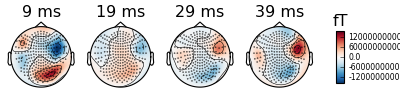

In [102]:
info = mne.io.read_info('1-raw.fif')
info = mne.pick_info(info, mne.pick_types(info, meg=True))
raw = mne.io.RawArray(meg[1][:, 0, :, 0].T, info)

ep = mne.Epochs(raw, array([[0, 0, 1]]), {'stim': 1}, 0.01, 0.04, baseline=(None, None), preload=True)

_ = ep['stim'].average().plot_topomap()